In [424]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

In [425]:
TrainingColums = ["nTracks","log(B_P)","log(gamma_PT)","log(Kst_892_0_PT)","B_Cone3_B_ptasy","B_ETA"]

sharedColums = ["nTracks","B_P","gamma_PT","B_Cone3_B_ptasy", 
                "B_ETA", "B_MINIPCHI2","B_SmallestDeltaChi2OneTrack",
                "B_FD_OWNPV","piminus_PT", "piminus_IP_OWNPV"]


columns    = {"kpi"  : sharedColums + ["Kst_892_0_PT","Kst_892_0_IP_OWNPV","Kplus_PT", "Kplus_IP_OWNPV" ],
              "pipi" : sharedColums + ["rho_770_0_PT","rho_770_0_IP_OWNPV","piplus_PT","piplus_IP_OWNPV"]}


modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"blue" : "#066bd6", "red" : "#d60645",  "pink" : "#2fad66", "green":"#2fad66","black":"#000000"}

In [426]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["kpi"]   = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))

#Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
    pipi_TTree_MC_up     = pipi_TChain_MC_up["DecayTree"]
    pipi_up_MC_df        = pipi_TTree_MC_up.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
    pipi_TTree_MC_down   = pipi_TChain_MC_down["DecayTree"]
    pipi_down_MC_df      = pipi_TTree_MC_down.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["pipi"]  = pd.concat((pipi_up_MC_df, pipi_down_MC_df))

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)


#Add min() colum to the dataframe
dataframes["kpi"  ]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpi"  ]["Kplus_IP_OWNPV"]),list(dataframes["kpi"  ]["piminus_IP_OWNPV"])) ]
dataframes["kpisw"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpisw"]["Kplus_IP_OWNPV"]),list(dataframes["kpisw"]["piminus_IP_OWNPV"])) ]

columns["kpi" ].append("min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" )
columns["pipi"].append("min(piminus_IP_OWNPV,piplus_IP_OWNPV)")

dataframes["kpi"]["log(B_MINIPCHI2)"]                             = np.log(dataframes["kpi"]["B_MINIPCHI2"])
dataframes["kpi"]["log(B_P)"]                                     = np.log(dataframes["kpi"]["B_P"])
dataframes["kpi"]["log(B_SmallestDeltaChi2OneTrack)"]             = np.log(dataframes["kpi"]["B_SmallestDeltaChi2OneTrack"])
dataframes["kpi"]["log(B_ETA)"]                                   = np.log(dataframes["kpi"]["B_ETA"])
dataframes["kpi"]["log(piminus_IP_OWNPV)"]                        = np.log(dataframes["kpi"]["piminus_IP_OWNPV"])
dataframes["kpi"]["log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))"]    = np.log(dataframes["kpi"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"])
dataframes["kpi"]["log(Kplus_PT)"]                                = np.log(dataframes["kpi"]["Kplus_PT"])
dataframes["kpi"]["log(piminus_PT)"]                              = np.log(dataframes["kpi"]["piminus_PT"])
dataframes["kpi"]["log(Kst_892_0_IP_OWNPV)"]                      = np.log(dataframes["kpi"]["Kst_892_0_IP_OWNPV"])
dataframes["kpi"]["log(Kst_892_0_PT)"]                            = np.log(dataframes["kpi"]["Kst_892_0_PT"])
dataframes["kpi"]["log(gamma_PT)"]                                = np.log(dataframes["kpi"]["gamma_PT"])
dataframes["kpi"]["log(B_FD_OWNPV)"]                              = np.log(dataframes["kpi"]["B_FD_OWNPV"])

dataframes["kpisw"]["log(B_MINIPCHI2)"]                           = np.log(dataframes["kpisw"]["B_MINIPCHI2"])
dataframes["kpisw"]["log(B_P)"]                                   = np.log(dataframes["kpisw"]["B_P"])
dataframes["kpisw"]["log(B_SmallestDeltaChi2OneTrack)"]           = np.log(dataframes["kpisw"]["B_SmallestDeltaChi2OneTrack"])
dataframes["kpisw"]["log(B_ETA)"]                                 = np.log(dataframes["kpisw"]["B_ETA"])
dataframes["kpisw"]["log(piminus_IP_OWNPV)"]                      = np.log(dataframes["kpisw"]["piminus_IP_OWNPV"])
dataframes["kpisw"]["log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))"]  = np.log(dataframes["kpisw"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"])
dataframes["kpisw"]["log(Kplus_PT)"]                              = np.log(dataframes["kpisw"]["Kplus_PT"])
dataframes["kpisw"]["log(piminus_PT)"]                            = np.log(dataframes["kpisw"]["piminus_PT"])
dataframes["kpisw"]["log(Kst_892_0_IP_OWNPV)"]                    = np.log(dataframes["kpisw"]["Kst_892_0_IP_OWNPV"])
dataframes["kpisw"]["log(Kst_892_0_PT)"]                          = np.log(dataframes["kpisw"]["Kst_892_0_PT"])
dataframes["kpisw"]["log(gamma_PT)"]                              = np.log(dataframes["kpisw"]["gamma_PT"])
dataframes["kpisw"]["log(B_FD_OWNPV)"]                            = np.log(dataframes["kpisw"]["B_FD_OWNPV"])

print("Data has been loaded")

Data has been loaded


/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [427]:
dataframes["kpi"]

,nTracks,B_P,gamma_PT,B_Cone3_B_ptasy,B_ETA,B_MINIPCHI2,B_SmallestDeltaChi2OneTrack,B_FD_OWNPV,piminus_PT,piminus_IP_OWNPV,...,log(B_SmallestDeltaChi2OneTrack),log(B_ETA),log(piminus_IP_OWNPV),"log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))",log(Kplus_PT),log(piminus_PT),log(Kst_892_0_IP_OWNPV),log(Kst_892_0_PT),log(gamma_PT),log(B_FD_OWNPV)
0,60,273883.848744,7018.973127,0.660959,3.587485,0.392829,17.547800,7.153876,2298.157129,0.195850,...,2.864929,1.277452,-1.630408,-2.278567,8.696341,7.739863,-2.077442,9.021615,8.856372,1.967654
1,60,273883.848744,7018.973127,0.660959,3.587485,0.392829,17.547800,7.153876,5980.988377,0.102431,...,2.864929,1.277452,-2.278567,-2.278567,7.739863,8.696341,-2.077442,9.021615,8.856372,1.967654
2,107,126785.577724,7158.783755,0.543079,3.211112,2.893996,313.574890,13.858021,2188.554096,1.494048,...,5.748038,1.166617,0.401489,-0.490724,6.894570,7.690996,0.132202,8.059657,8.876095,2.628864
3,131,100415.996715,6545.822352,0.551857,2.554097,8.310109,84.313843,10.304591,4558.507548,0.412559,...,4.434546,0.937699,-0.885376,-0.931879,8.555185,8.424751,-0.946742,9.185044,8.786582,2.332590
4,131,100415.996715,6545.822352,0.551857,2.554097,8.310109,84.313843,10.304591,5193.613137,0.393813,...,4.434546,0.937699,-0.931879,-0.931879,8.424751,8.555185,-0.946742,9.185044,8.786582,2.332590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105804,243,84931.574490,3954.462812,0.587744,2.321838,0.451742,12.087173,5.578162,6277.329459,0.250190,...,2.492145,0.842359,-1.385535,-1.681706,8.853083,8.744700,-1.545086,9.492644,8.282600,1.718859
105805,189,136018.777381,6168.203203,0.083082,3.217236,2.407127,7.364946,18.615648,1463.252400,0.461360,...,1.996732,1.168523,-0.773576,-0.773576,8.217706,7.288417,-0.516956,8.550305,8.727163,2.924003
105806,189,136018.777381,6168.203203,0.083082,3.217236,2.407127,7.364946,18.615648,3705.990062,0.656324,...,1.996732,1.168523,-0.421101,-0.773576,7.288417,8.217706,-0.516956,8.550305,8.727163,2.924003
105807,206,77078.946405,5078.961409,-0.097834,2.489899,2.150364,3.362027,4.061175,6856.574867,0.196109,...,1.212544,0.912242,-1.629084,-1.629084,7.399253,8.832963,-1.567287,9.046140,8.532862,1.401472


In [428]:
# divide original samples into training ant test parts
kpiMC_train, kpiMC_test = train_test_split(dataframes["kpi"])
# divide target samples into training ant test partss
kpiSW_train, kpiSW_test = train_test_split(dataframes["kpisw"])

kpiMC_weights_train = np.ones(len(kpiMC_train))
kpiMC_weights_test  = np.ones(len(kpiMC_test))

kpiSW_weights_train = kpiSW_train["NB0_Kpigamma_sw"]
kpiSW_weights_test  = kpiSW_test["NB0_Kpigamma_sw"]
print("Data has been Split")


Data has been Split


In [450]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=50,  learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={'subsample': 0.4})
#GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=4)
GradientBoostedReweighter.fit(kpiMC_train[TrainingColums], kpiSW_train[TrainingColums], original_weight=kpiMC_weights_train, target_weight=kpiSW_weights_train)

FittedWeights_test  = GradientBoostedReweighter.predict_weights(kpiMC_test[ TrainingColums])
FittedWeights_train = GradientBoostedReweighter.predict_weights(kpiMC_train[TrainingColums])

Mean Test Improvement: 6.93%
Mean Train Improvement: 7.95%


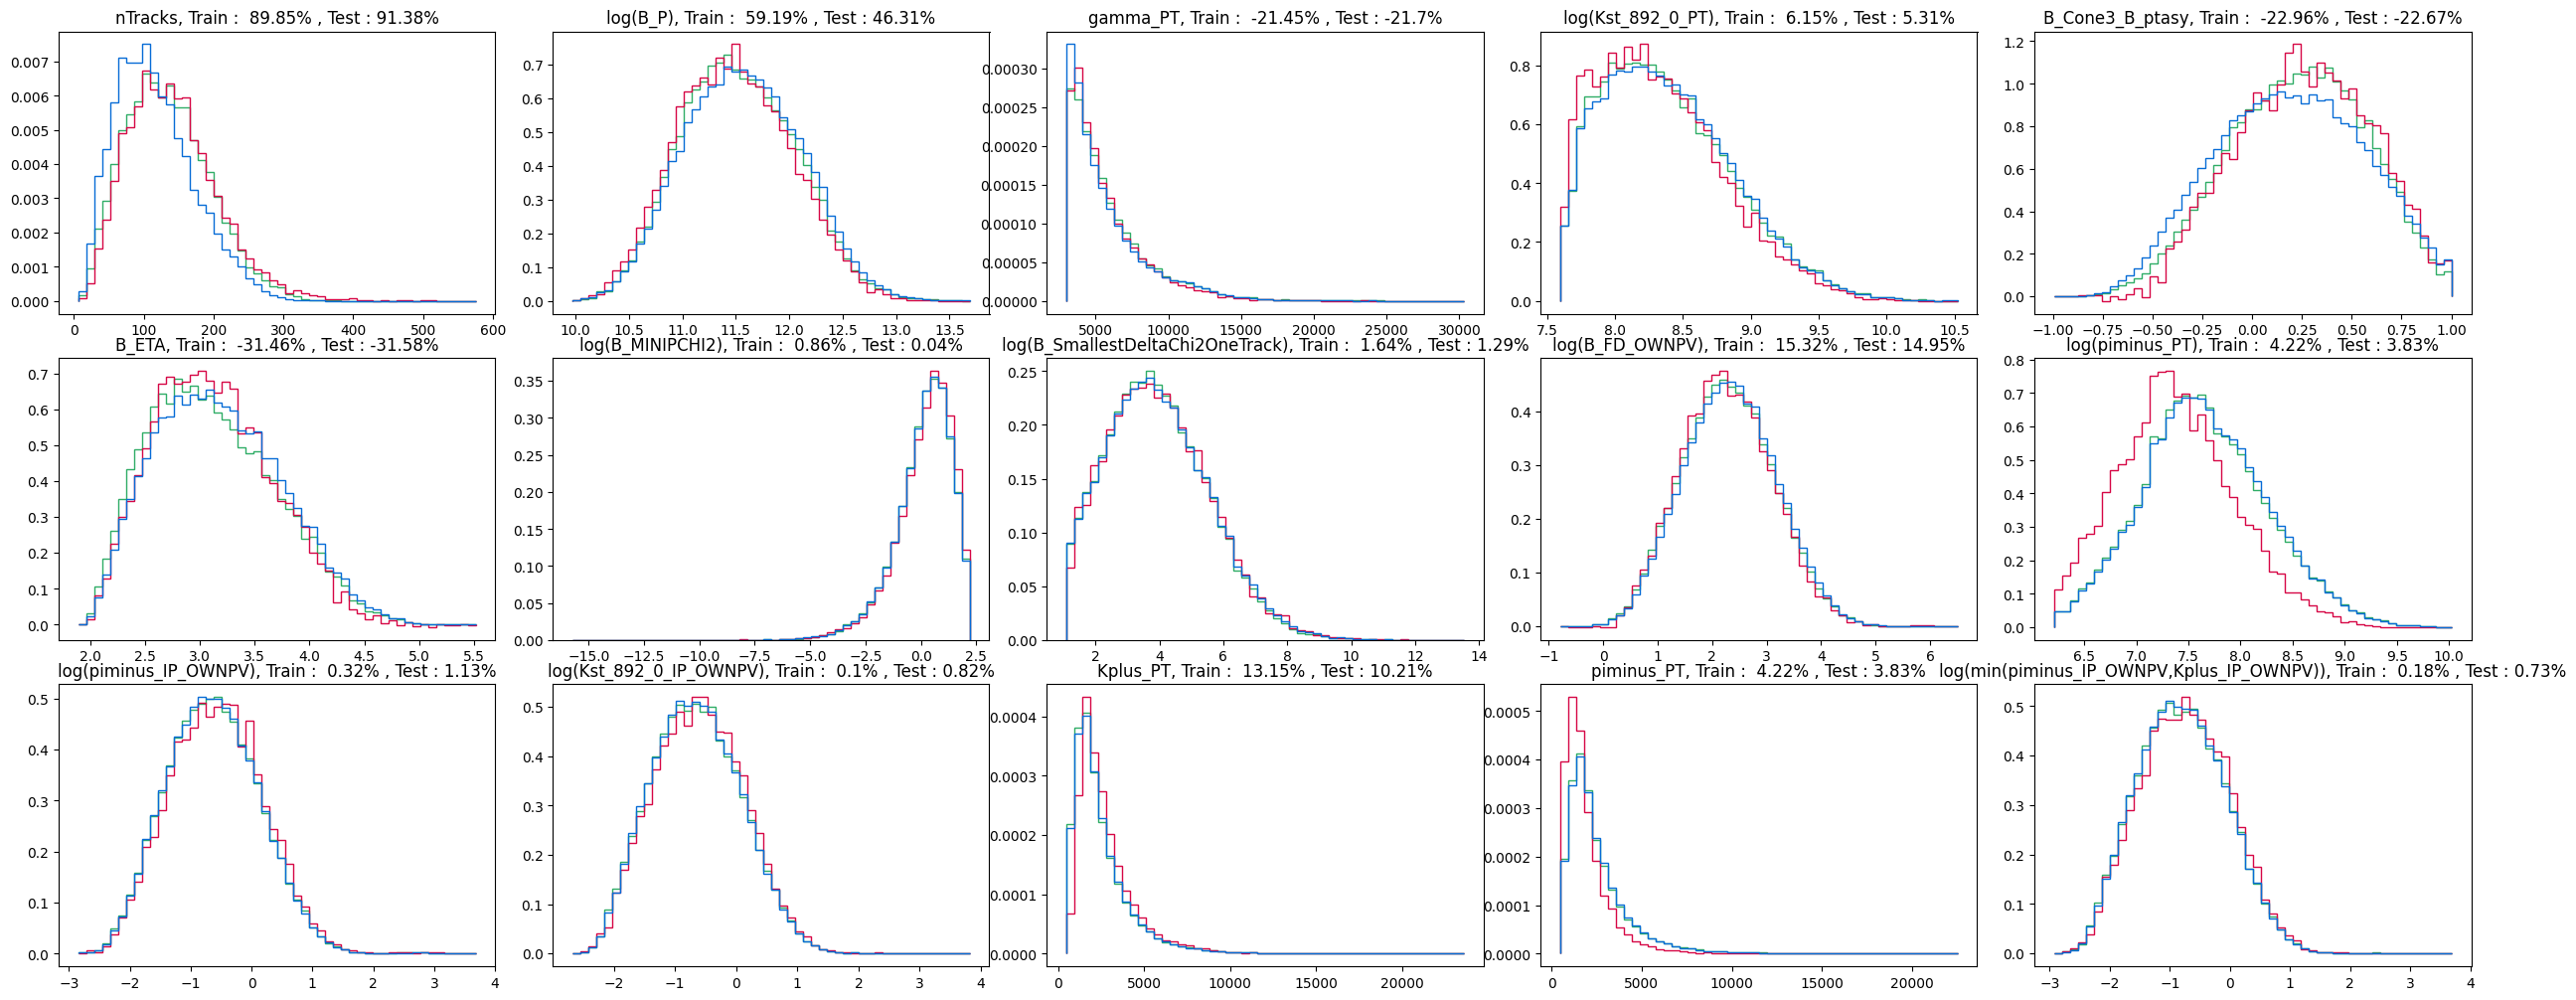

In [451]:

def CreateLargeCanvasOfDoublePlots():

    PlotingColums = np.array( ["nTracks","log(B_P)", "gamma_PT","log(Kst_892_0_PT)", "B_Cone3_B_ptasy", "B_ETA", 
                               "log(B_MINIPCHI2)", "log(B_SmallestDeltaChi2OneTrack)", "log(B_FD_OWNPV)","log(piminus_PT)", "log(piminus_IP_OWNPV)",
                               "log(Kst_892_0_IP_OWNPV)", "Kplus_PT", "piminus_PT", "log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))"] )
    
    canvas, axes = plt.subplots(3,5,figsize=(25, 10))
    canvas.tight_layout()
    index = 0
    KS_change_test  = 0
    KS_change_train = 0

    for ax in axes.flat:

        variable = PlotingColums[index]
        
        hist_kpi_y,   hist_kpi_x,   _  = ax.hist(  [kpiMC_test[variable], kpiSW_test[variable], kpiMC_test[variable]], 
                                         weights = [kpiMC_weights_test,   kpiSW_weights_test,   FittedWeights_test], 
                                         color   = [colors["blue"],       colors["red"],        colors["green"]], 
                                         label   = ["Kpi MC",             "Kpi Sample",         "Kpi MC Reweighted"], 
                                         **hist_style )
        index += 1

        KS_before_test = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=kpiMC_weights_test, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
        KS_After_test  = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=FittedWeights_test, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
        KS_change_test += (KS_before_test/KS_After_test - 1)

        KS_before_train = ks_2samp_weighted(kpiMC_train[variable], kpiSW_train[variable], weights1=kpiMC_weights_train, weights2=np.ones(len(kpiSW_train[variable]), dtype=float))
        KS_After_train  = ks_2samp_weighted(kpiMC_train[variable], kpiSW_train[variable], weights1=FittedWeights_train, weights2=np.ones(len(kpiSW_train[variable]), dtype=float))
        KS_change_train += (KS_before_train/KS_After_train - 1)


        ax.set_title(f"{variable}, Train :  {np.round((KS_before_train/KS_After_train - 1)*100,2)}% , Test : {np.round((KS_before_test/KS_After_test - 1)*100,2)}%")

    meanKSR_test  = (KS_change_test / len(PlotingColums))*100
    meanKSR_train = (KS_change_train / len(PlotingColums))*100

    print(f"Mean Test Improvement: {np.round(meanKSR_test,2)}%")
    print(f"Mean Train Improvement: {np.round(meanKSR_train,2)}%")
    
    canvas.savefig("../imgs/superCanvas.png")


CreateLargeCanvasOfDoublePlots()


In [ ]:


def CreateDoublePlot(variable, Reweighter, TrainingColums):

    #Create Canvas
    canvas, (disti,ratio) = plt.subplots(2,1, gridspec_kw={"height_ratios" : [2,1] },figsize=(8, 7))
    canvas.tight_layout()

    #Create Histograms
    xLowerBound = max( min(kpiMC_train[variable]), min(kpiSW_train[variable]) )
    xUpperBound = min( max(kpiMC_train[variable]), max(kpiSW_train[variable]) )
   
    #Compute New Weights
    FittedWeights = Reweighter.predict_weights(kpiMC_test[TrainingColums])

    #Draw Histograms
    hist_kpi_y,   hist_kpi_x,   _  = disti.hist( [kpiMC_test[variable], kpiSW_test[variable], kpiMC_test[variable]], 
                                     weights = [kpiMC_weights_test,   kpiSW_weights_test,   FittedWeights], 
                                     color   = [colors["blue"],       colors["red"],        colors["green"]], 
                                     label   = ["Kpi MC",             "Kpi Sample",         "Kpi MC Reweighted"], 
                                     **hist_style )

    #Plot Ratio Data
    ratio_data        = np.nan_to_num( (hist_kpi_y[1] / hist_kpi_y[0]), nan=-1, posinf=-1, neginf=-1)
    ratio_data_fitted = np.nan_to_num( (hist_kpi_y[1] / hist_kpi_y[2]), nan=-1, posinf=-1, neginf=-1)

    ratio.scatter(hist_kpi_x[:-1], ratio_data, c=colors["blue"], s=5)
    ratio.scatter(hist_kpi_x[:-1], ratio_data_fitted, c=colors["green"], s=5)

    #Calculate KSR
    KS_before = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=kpiMC_weights_test, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
    KS_After  = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=FittedWeights,      weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
    KS_resid = KS_before - KS_After

    #Styles
    disti.set_title(f"{variable}   KSR: {np.round(KS_resid,4)}")
    disti.grid(axis="both", linestyle="dashed", alpha=0.5)
    disti.set_xlim(xLowerBound, xUpperBound)
    disti.xaxis.set_tick_params(which = "both",labelbottom=False, bottom=False)
    disti.legend()

    ratio.grid(axis="both", linestyle="dashed", alpha=0.5)
    ratio.set_xlim(xLowerBound, xUpperBound)
    ratio.set_yscale("log")

    plt.savefig(f"../imgs/{variable}.png")

    return KS_resid


In [ ]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.02, max_depth=4, min_samples_leaf=1000, gb_args={'subsample': 0.4})
#GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=2)
GradientBoostedReweighter.fit(kpiMC_train[TrainingColums], kpiSW_train[TrainingColums], original_weight=kpiMC_weights_train, target_weight=kpiSW_weights_train)

GBReweighter(gb_args={'subsample': 0.4}, learning_rate=0.02, max_depth=4,
             min_samples_leaf=1000, n_estimators=250)

/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/3027481705.py:22: RuntimeWarning: divide by zero encountered in divide
  ratio_data        = np.nan_to_num( (hist_kpi_y[1] / hist_kpi_y[0]), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/3027481705.py:22: RuntimeWarning: invalid value encountered in divide
  ratio_data        = np.nan_to_num( (hist_kpi_y[1] / hist_kpi_y[0]), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/3027481705.py:23: RuntimeWarning: divide by zero encountered in divide
  ratio_data_fitted = np.nan_to_num( (hist_kpi_y[1] / hist_kpi_y[2]), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/3027481705.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_data_fitted = np.nan_to_num( (hist_kpi_y[1] / hist_kpi_y[2]), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel

Total Residual: 0.05489342977331585


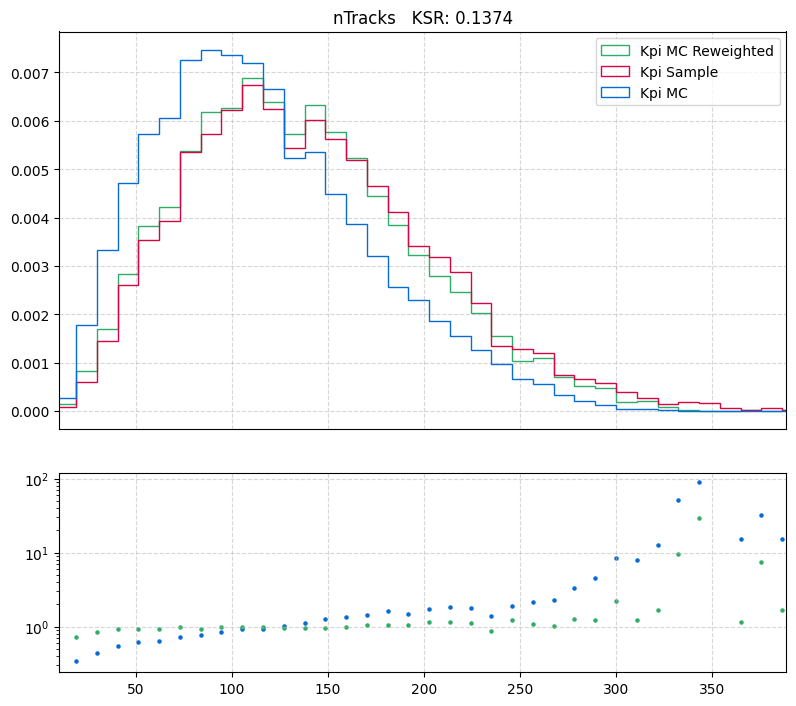

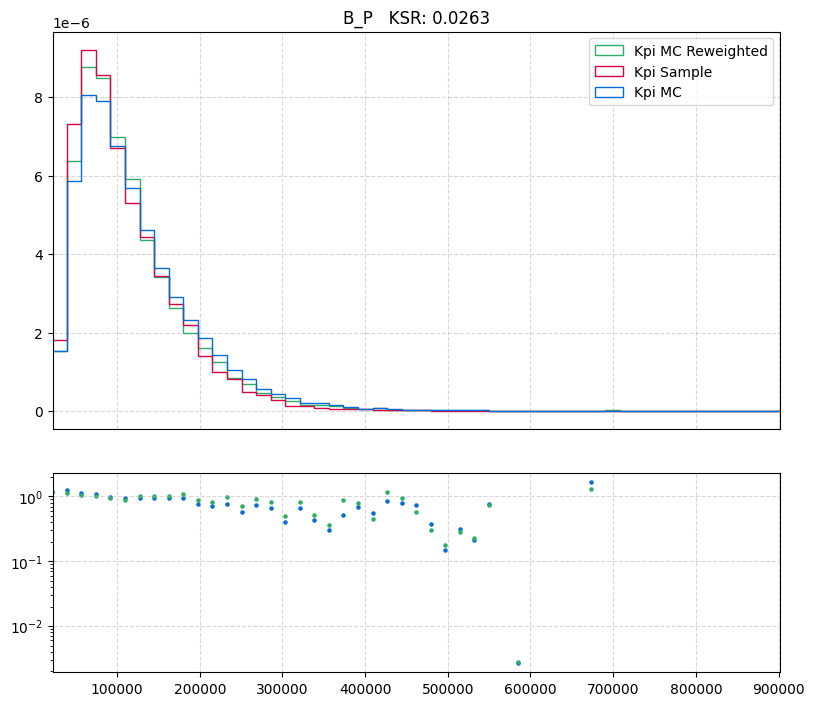

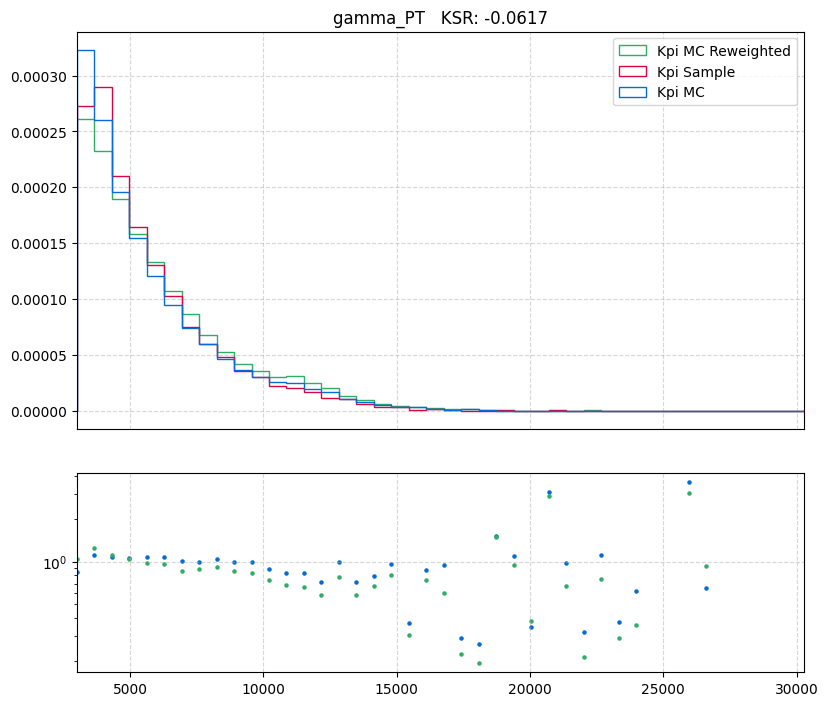

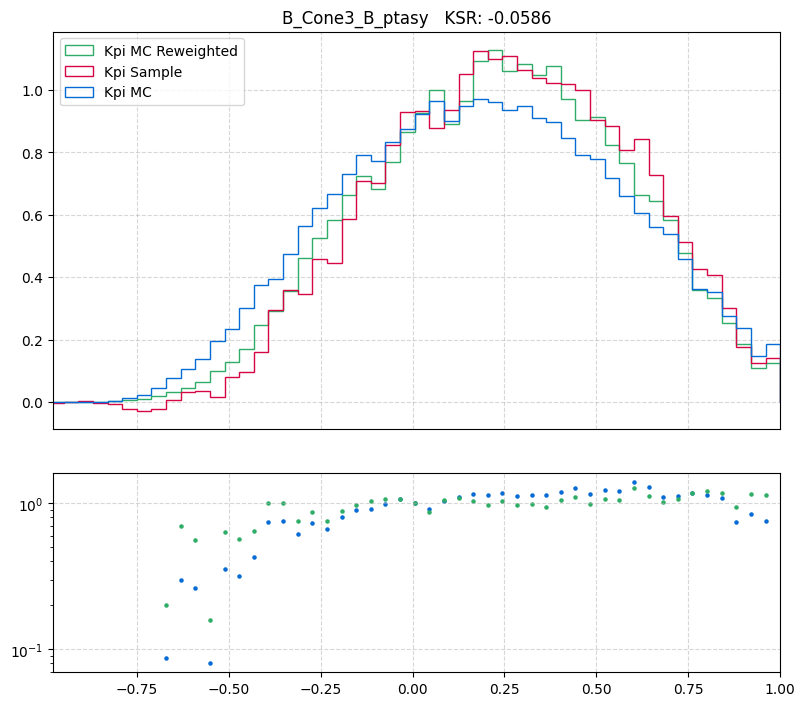

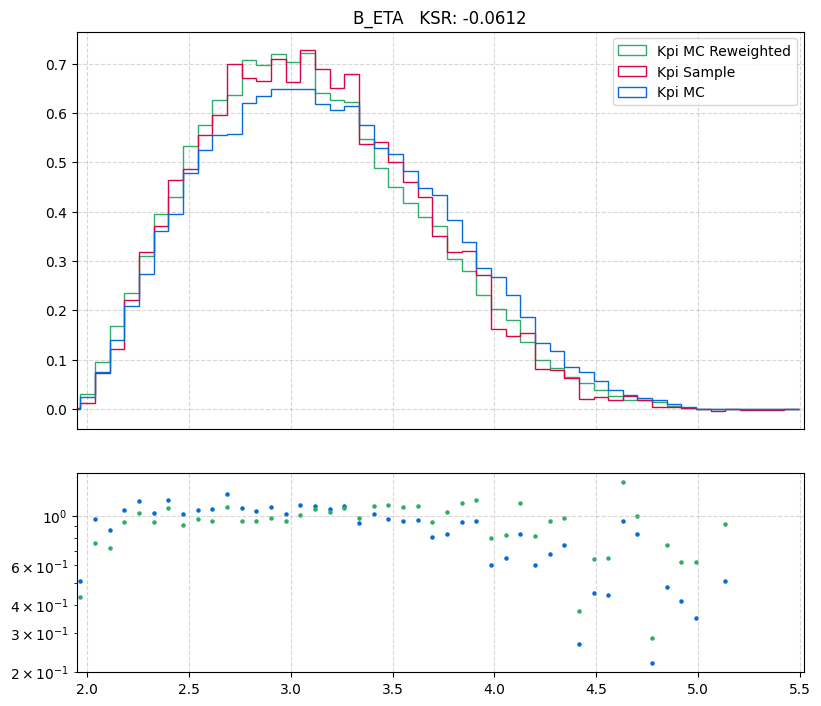

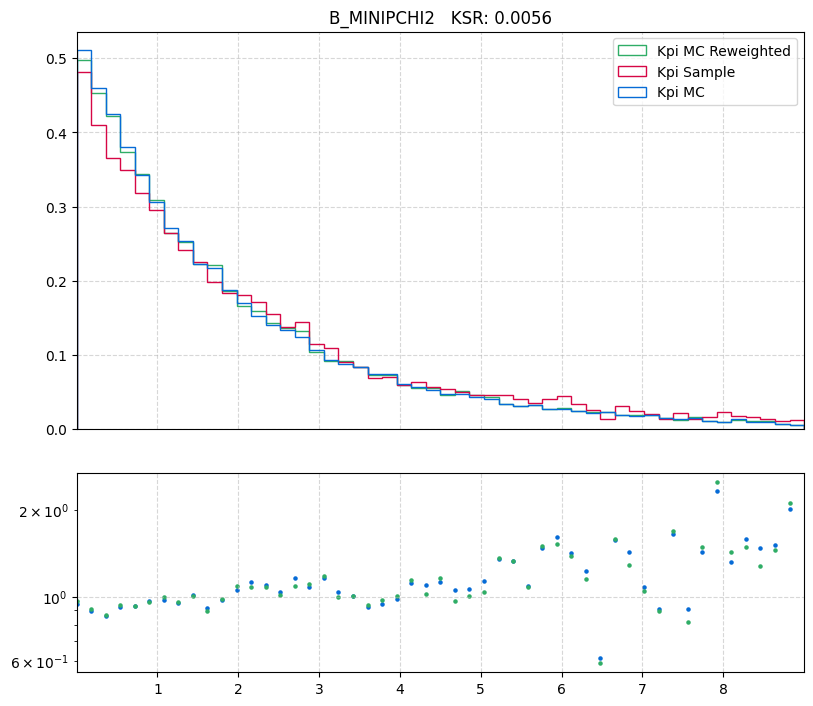

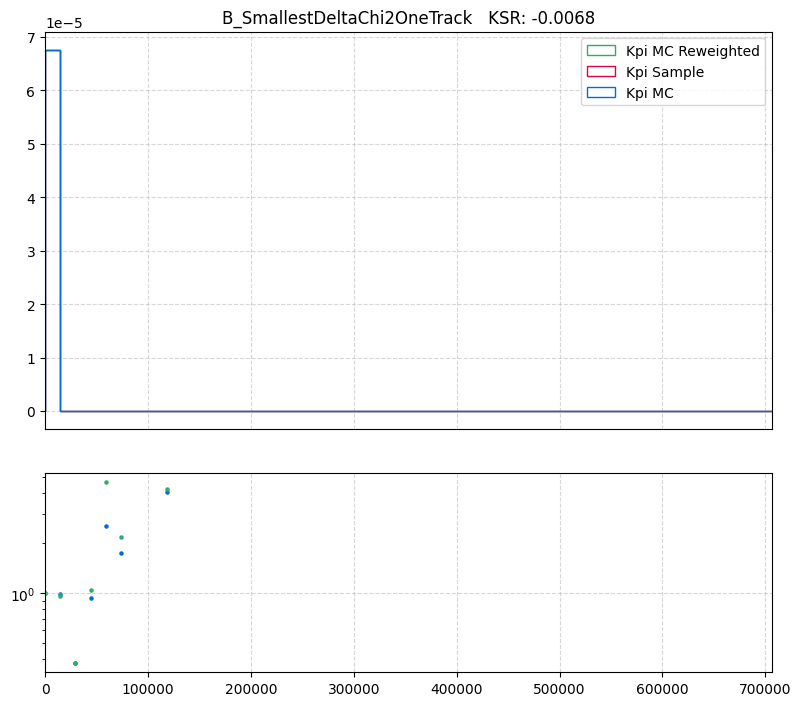

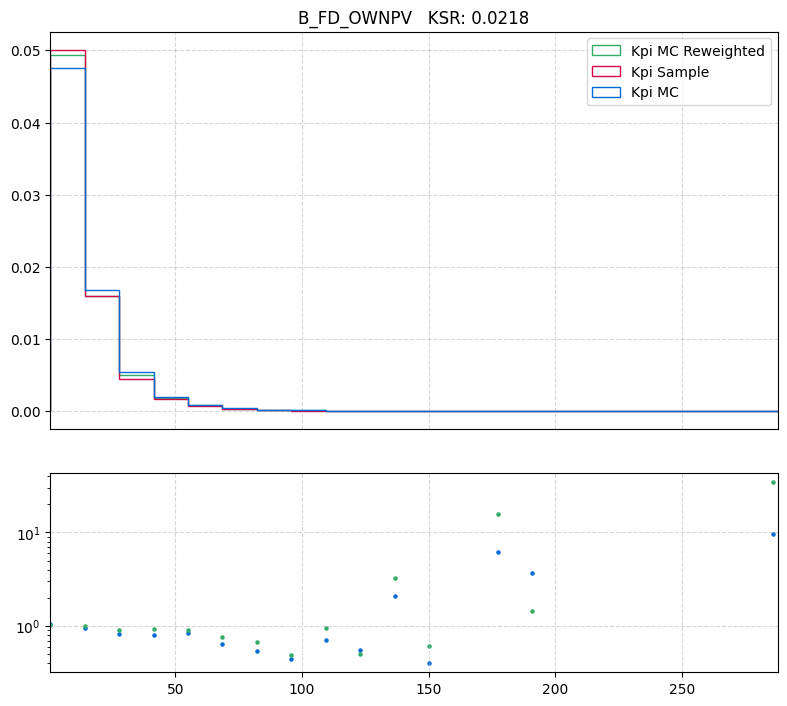

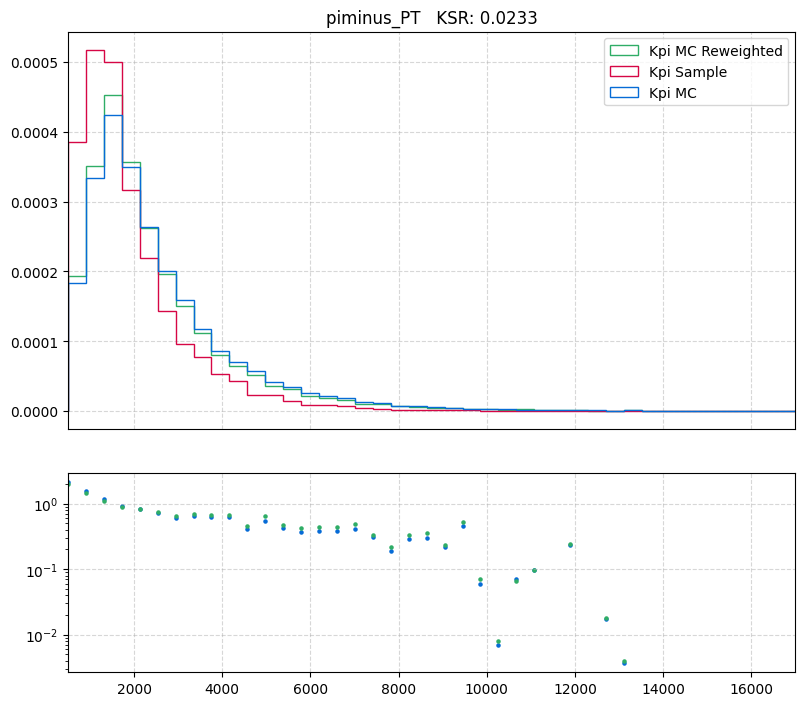

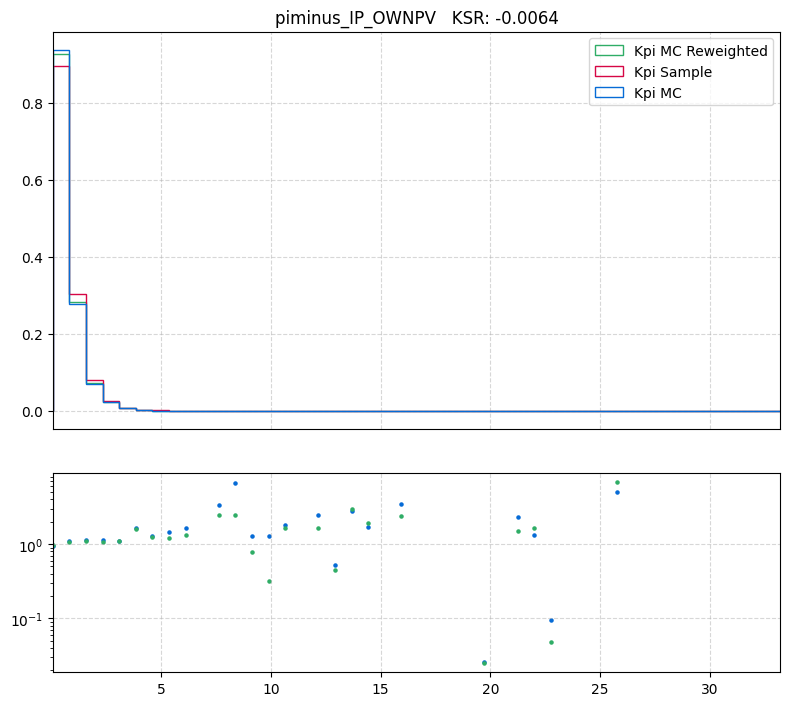

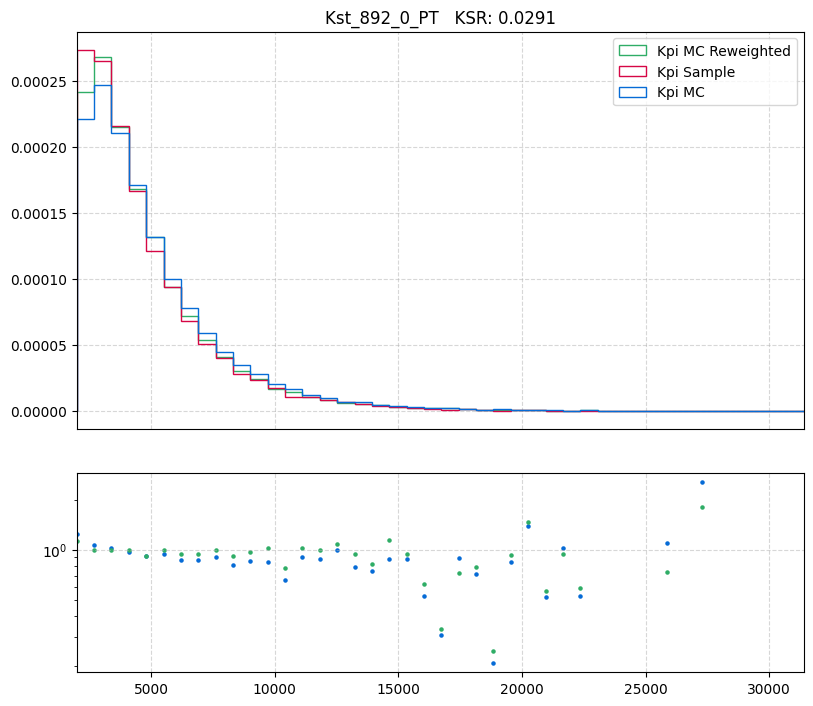

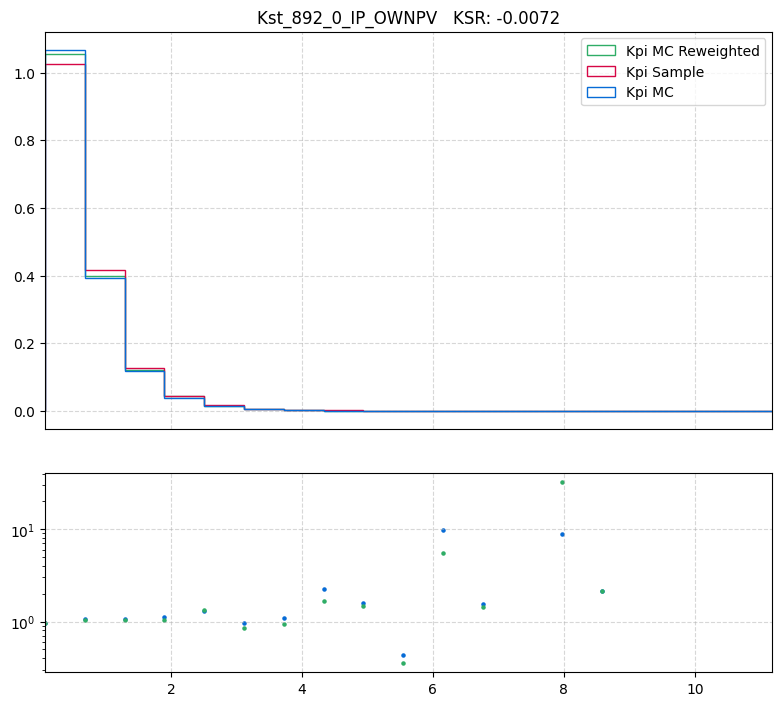

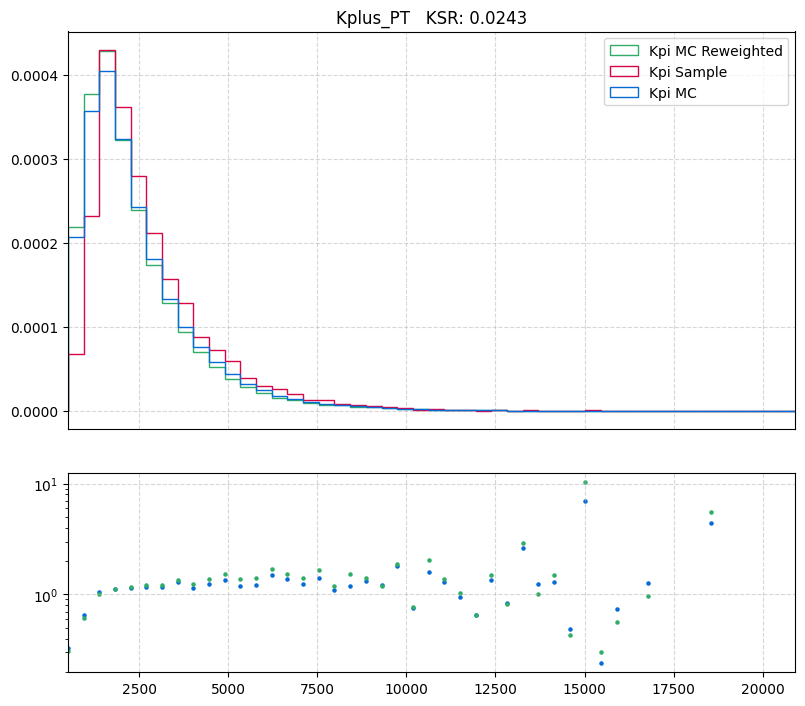

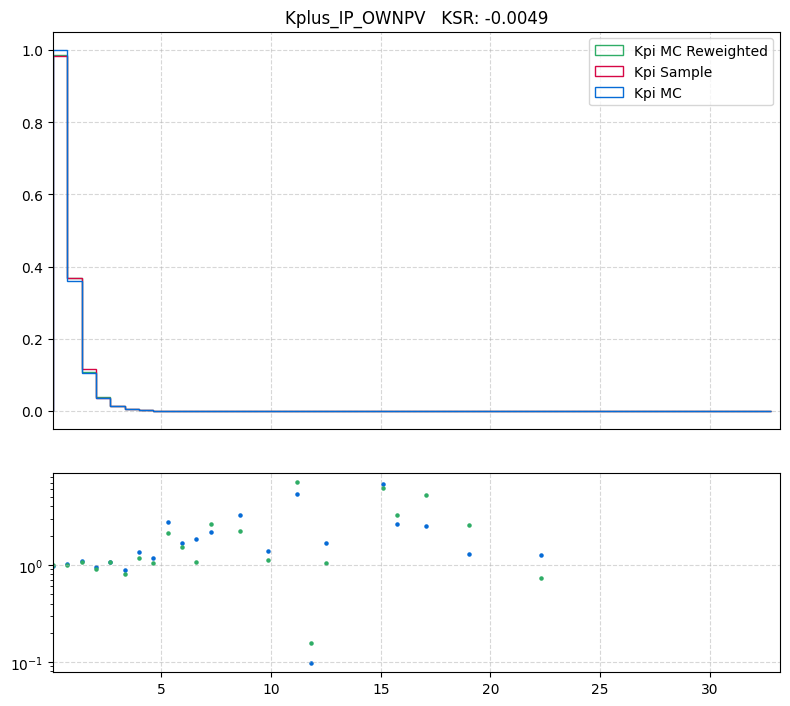

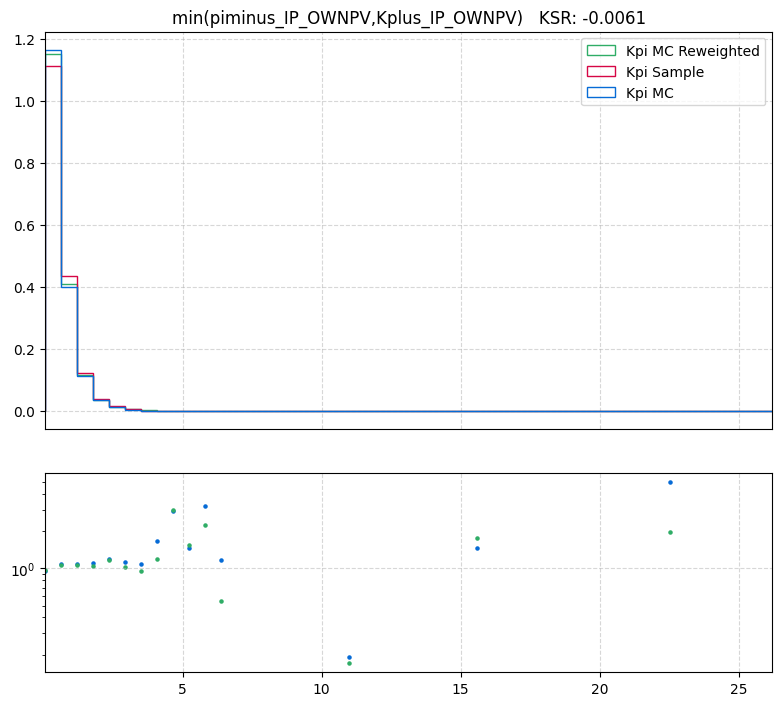

In [ ]:
KSR_Gamma = 0

for var in columns["kpi"]:

    KSR_Gamma += CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighter, TrainingColums=TrainingColums)
    
print("Total Residual:", KSR_Gamma)


In [ ]:
# TrainingColumsSansGamma = TrainingColums.copy()
# TrainingColumsSansGamma.remove("gamma_PT")

# GradientBoostedReweighterSansGamma = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={'subsample': 0.4})
# #GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=2)
# GradientBoostedReweighterSansGamma.fit(kpiMC_train[TrainingColumsSansGamma], kpiSW_train[TrainingColumsSansGamma])

In [ ]:
#Code to test if gamma_PT increases Performance

# KSR_Gamma = KSR_sansGamma = 0


# for var in columns["kpi"]:

#     if var == "gamma_PT":
#         continue

#     KSR_Gamma     += abs(CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighter,          TrainingColums=TrainingColums))
#     KSR_sansGamma += abs(CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighterSansGamma, TrainingColums=TrainingColumsSansGamma))

# print("With Gamma    :", KSR_Gamma)
# print("Without Gamma :", KSR_sansGamma)

In [ ]:
# xLowerBound = min( list(kpiMC_test[variable]) + list(kpiSW_test[variable]) )
# xUpperBound = max( list(kpiMC_test[variable]) + list(kpiSW_test[variable]) )

# hist_kpi_y,   hist_kpi_x,   _      = plt.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpi"],  weights = kpiMC_weights_test, label="Kpi MC",     **hist_style)
# hist_kpisw_y, hist_kpisw_x, _      = plt.hist(kpiSW_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpisw"],weights = kpiSW_weights_test, label="Kpi Sample", **hist_style)
# hist_trained_kpi_y, hist_kpi_x, _  = plt.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["rw"],   weights = FittedWeights,      label="Kpi MC Reweighted",  **hist_style)


# plt.show()